In [1]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import os
from typing import Optional
from dotenv import load_dotenv
from IPython.display import  Image, display

In [7]:
load_dotenv()
openai_api_key=os.getenv('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)

C:\Users\alber\AppData\Local\Temp\ipykernel_14456\1903895123.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)


In [3]:
# Definição do estado
class State(dict):
    mensagem: str
    resumo: Optional[str]
    valido: Optional[bool]
    resultado: Optional[str]

# Criar o estado inicial
def criar_estado_inicial(texto):
    return {
        "mensagem": texto,
        "resumo": None,
        "valido": None,
        "resultado": None
    }

# Nó 1: Gerar resumo
def gerar_resumo(state):
    prompt = ChatPromptTemplate.from_template(
        "Resuma o texto abaixo em até 30 palavras:\n{mensagem}"
    )
    resposta = llm.invoke(prompt.format_messages(mensagem=state["mensagem"]))
    state["resumo"] = resposta.content.strip()
    return state

# Nó 2: Verificar resumo
def verificar_resumo(state):
    palavras = state["resumo"].split()
    if len(palavras) <= 30:
        state["valido"] = True
        state["resultado"] = f"Resumo aprovado com {len(palavras)} palavras:\n{state['resumo']}"
    else:
        state["valido"] = False
    return state

# Função condicional: decidir próximo passo
def decidir_proximo(state):
    if state["valido"]:
        return "finalizar"
    else:
        return "gerar_resumo"

# Nó 3: Finalizar
def finalizar(state):
    return state

In [4]:
graph = StateGraph(State)

graph.add_node("gerar_resumo", gerar_resumo)
graph.add_node("verificar_resumo", verificar_resumo)
graph.add_node("finalizar", finalizar)

graph.set_entry_point("gerar_resumo")
graph.add_edge("gerar_resumo", "verificar_resumo")
graph.add_conditional_edges("verificar_resumo", decidir_proximo)
graph.add_edge("finalizar", END)

app = graph.compile()


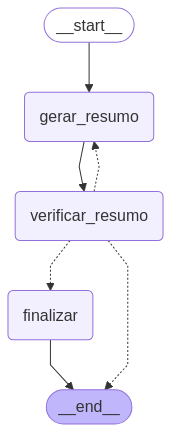

In [5]:
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
texto = (
    "LangGraph é um framework que facilita a criação de agentes baseados em grafos, "
    "permitindo execução condicional, paralela e ciclos de interação, além de integração com ferramentas externas."
)

estado = criar_estado_inicial(texto)
resultado = app.invoke(estado)

print("\n--- Resultado Final ---")
print(resultado["resultado"])



--- Resultado Final ---
Resumo aprovado com 20 palavras:
LangGraph é um framework para criar agentes baseados em grafos, suportando execução condicional, paralela, ciclos e integração com ferramentas externas.
